In [1]:
pip install protobuf==3.20.*


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import music21
import subprocess

[[-603.7592 -603.7592 -603.7592 ... -603.7592 -603.7592 -603.7592]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]


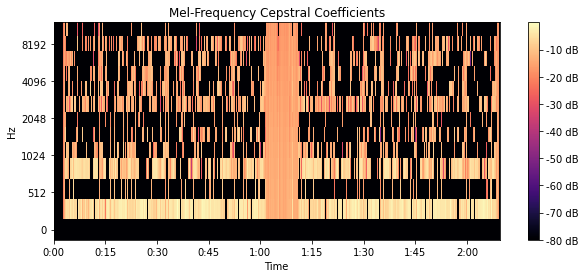

In [4]:
# Load the WAV file
audio_file = "data/en001a.wav"

y, sr = librosa.load(audio_file, sr=None)  # sr=None to preserve the original sampling rate

# Extract Mel-Frequency Cepstral Coefficients (MFCCs)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # To adjust the number of MFCC coefficients (n_mfcc)
print(mfccs)

# Visualize the MFCCs
plt.figure(figsize=(10, 4))

librosa.display.specshow(librosa.power_to_db(mfccs, ref=np.max), y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')

plt.title('Mel-Frequency Cepstral Coefficients')

plt.show()

In [5]:
# Assuming you have corresponding labels for each time step
# Replace this with your actual target labels
labels = np.random.randint(0, 2, size=mfccs.shape[1])  # Replace with actual labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfccs.T, labels, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (batch_size, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model with two LSTM layers and a binary output
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Optional Dropout layer for regularization
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))  # Adjust the output layer based on your task

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 5s 7ms/step - loss: 0.6937 - accuracy: 0.5064 - val_loss: 0.6937 - val_accuracy: 0.5067
Epoch 2/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5080 - val_loss: 0.6936 - val_accuracy: 0.4915
Epoch 3/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5059 - val_loss: 0.6953 - val_accuracy: 0.4736
Epoch 4/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5120 - val_loss: 0.6962 - val_accuracy: 0.4933
Epoch 5/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4943 - val_loss: 0.6952 - val_accuracy: 0.4754
Epoch 6/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6950 - val_accuracy: 0.4933
Epoch 7/10
140/140 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4979 - val_loss: 0.6947 - val_accuracy: 0.4942
Epoch 

In [6]:
# Assuming your model is trained, now predict pitch labels for a new sequence
predicted_probabilities = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1) based on a threshold
threshold = 0.5  # Adjust this threshold based on your task
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Convert binary labels to MIDI notes with a fixed pitch and duration
midi_notes = [music21.note.Note(pitch=60, quarterLength=0.5) if label == 1 else music21.note.Rest(quarterLength=0.5) for label in predicted_labels.flatten()]

# Create a music21 stream to represent the sheet music
s = music21.stream.Score()
p = music21.stream.Part()

# Add key and time signature
p.append(music21.key.KeySignature(0))  # C major
p.append(music21.meter.TimeSignature('4/4'))

# Add notes to the part based on the predicted MIDI notes
p.append(midi_notes)

# Add the part to the score
s.append(p)

In [7]:
# Save the MIDI file
midi_file_path = "midi-output/predicted_music.mid"
s.write('midi', fp=midi_file_path)

# Step 1: Load the MIDI file
midi_file_path = "midi-output/predicted_music.mid"
midi_stream = music21.converter.parse(midi_file_path)

# Step 2: Convert MIDI file into a music21 Score object
score = music21.stream.Score()
for part in midi_stream.parts:
    # Instead of inserting at position 0, insert at the end of the score
    score.append(part)
    
# Step 3: Show or save the Score object as sheet music
# You can either show the score
# score.show()

# Or save it as a PDF or other formats
ly_file_path = "lilypond-export/en001a_sheet_music.ly"
score.write('lilypond', ly_file_path)

# Step 4: Convert LilyPond file to PDF or SVG using LilyPond software
# You can do this manually using LilyPond software or command line
# Or you can use a library or tool to automate the conversion process
# For example, you can use the `subprocess` module to run LilyPond from Python

# Example using subprocess (requires LilyPond installed on your system):
import subprocess
output_file_name = "sheet-music-export/en001a_sheet"
subprocess.run(['lilypond', '--pdf', '-o', output_file_name, ly_file_path])  # Convert to PDF

CompletedProcess(args=['lilypond', '--pdf', '-o', 'sheet-music-export/en001a_sheet', 'lilypond-export/en001a_sheet_music.ly'], returncode=1)